https://www.kaggle.com/gopidurgaprasad/netflix-appetency-stater-eda-model

In [ ]:
! pip install kaggle

In [ ]:
# Colab library to upload files to notebook
from google.colab import files

# Upload kaggle API key file
uploaded = files.upload()

uploaded

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhargava39","key":"66bc8f96f9f32e3dc1b9962d882cfc99"}'}

In [ ]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle -v

Kaggle API 1.5.12


In [ ]:
! kaggle competitions download -c netflix-appetency

 27% 9.00M/33.2M [00:00<00:00, 52.9MB/s]
100% 33.2M/33.2M [00:00<00:00, 127MB/s] 


In [ ]:
! unzip netflix-appetency.zip

Archive:  netflix-appetency.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
! pip install --upgrade category_encoders
! pip install --upgrade catboost
! pip install --upgrade optuna

     |████████████████████████████████| 86 kB 2.4 MB/s 


In [ ]:
import os
import sys
import glob
import math
import random

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import cycle

from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree

import category_encoders as ce
import lightgbm as lgb
import xgboost as xgb
import catboost as cat

from random import choice, choices
pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()['color'])

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
ss = pd.read_csv("sample_submission.csv")

print(train.shape, test.shape, ss.shape)

(70000, 509) (30000, 508) (30000, 2)


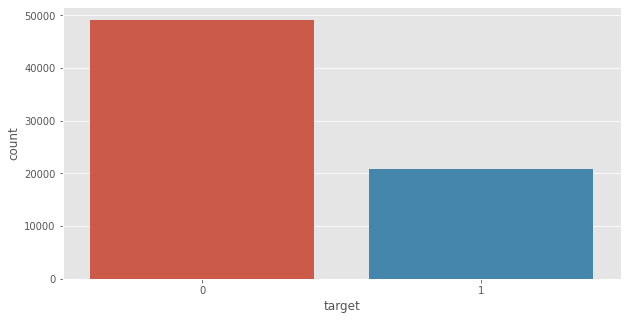

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
sns.countplot(train.target)
plt.show()

In [ ]:
train.head()

,id,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature

In [ ]:
train.drop(columns = ['id', 'target']).duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
69995    False
69996    False
69997    False
69998    False
69999    False
Length: 70000, dtype: bool

In [ ]:
train.drop(columns = ['id', 'target']).duplicated().unique()

array([False,  True])

In [ ]:
train.drop(columns = ['id', 'target']).duplicated().nunique()

2

In [ ]:
train.drop(columns = ['id', 'target']).duplicated().sum()

1

In [ ]:
train = train.drop_duplicates().reset_index(drop=True)
train.shape

(70000, 509)

In [ ]:
display(train.isna().sum(axis=0).sort_values(ascending=False).to_frame().T)

,feature_193,feature_196,feature_197,feature_198,feature_83,feature_76,feature_75,feature_195,feature_11,feature_5,feature_8,feature_12,feature_9,feature_6,feature_10,feature_13,feature_7,feature_86,feature_85,feature_84,feature_203,feature_172,feature_255,feature_202,feature_194,feature_204,feature_153,feature_200,feature_257,feature_206,feature_154,feature_157,feature_160,feature_258,feature_155,feature_158,feature_161,feature_207,feature_260,feature_156,feature_159,feature_256,feature_259,feature_60,feature_162,feature_208,feature_192,feature_94,feature_128,feature_67,feature_129,feature_254,feature_88,feature_68,feature_90,feature_92,feature_91,feature_130,feature_131,feature_89,feature_132,feature_93,feature_81,feature_191,feature_201,feature_95,feature_37,feature_39,feature_35,feature_36,feature_38,feature_40,feature_96,feature_361,feature_359,feature_358,feature_357,feature_356,feature_355,feature_360,feature_362,feature_367,feature_363,feature_375,feature_384,feature_383,feature_382,feature_381,feature_380,feature_379,feature_378,feature_377,feature_376,feature_374,feature_364,feature_373,feature_372,feature_371,feature_370,feature_369,feature_368,feature_353,feature_366,feature_365,feature_354,id,feature_352,feature_351,feature_319,feature_318,feature_317,feature_316,feature_315,feature_314,feature_313,feature_312,feature_311,feature_310,feature_309,feature_308,feature_307,feature_306,feature_305,feature_304,feature_303,feature_302,feature_301,feature_300,feature_299,feature_298,feature_297,feature_296,feature_295,feature_294,feature_293,feature_292,feature_291,feature_320,feature_321,feature_322,feature_338,feature_350,feature_349,feature_348,feature_347,feature_346,feature_386,feature_345,feature_344,feature_343,feature_342,feature_341,feature_340,feature_339,feature_337,feature_323,feature_336,feature_335,feature_334,feature_333,feature_332,feature_331,feature_330,feature_329,feature_328,feature_327,feature_326,feature_325,feature_324,feature_385,feature_401,feature_387,feature_388,feature_475,feature_474,feature_473,feature_472,feature_471,feature_470,feature_469,feature_468,feature_467,feature_466,feature_465,feature_464,feature_463,feature_462,feature_461,feature_460,feature_459,feature_458,feature_457,feature_456,feature_455,feature_454,feature_453,feature_452,feature_451,feature_450,feature_449,feature_476,feature_477,feature_478,feature_493,feature_505,feature_504,feature_503,feature_502,feature_501,feature_500,feature_499,feature_498,feature_497,feature_496,feature_495,feature_494,feature_492,feature_479,feature_491,feature_490,feature_489,feature_488,feature_487,feature_486,feature_485,feature_484,feature_483,feature_482,feature_481,feature_480,feature_448,feature_447,feature_446,feature_402,feature_414,feature_413,feature_412,feature_411,feature_410,feature_409,feature_408,feature_407,feature_406,feature_405,feature_404,feature_403,feature_289,feature_416,feature_400,feature_399,feature_398,feature_397,feature_396,feature_395,feature_394,feature_393,feature_392,feature_391,feature_390,feature_389,feature_415,feature_417,feature_445,feature_432,feature_444,feature_443,feature_442,feature_441,feature_440,feature_439,feature_438,feature_437,feature_436,feature_435,feature_434,feature_433,feature_431,feature_418,feature_430,feature_429,feature_428,feature_427,feature_426,feature_425,feature_424,feature_423,feature_422,feature_421,feature_420,feature_419,feature_290,feature_252,feature_288,feature_100,feature_111,feature_110,feature_109,feature_108,feature_107,feature_106,feature_105,feature_104,feature_103,feature_102,feature_101,feature_99,feature_145,feature_98,feature_97,feature_87,feature_82,feature_80,feature_79,feature_78,feature_77,feature_74,feature_73,feature_72,feature_112,feature_113,feature_114,feature_115,feature_143,feature_142,feature_141,feature_140,feature_139,feature_138,feature_137,feature_136,feature_135,feature_134,feature_133,feature_127,feature_126,feature_125,feature_124,feature_123,fea

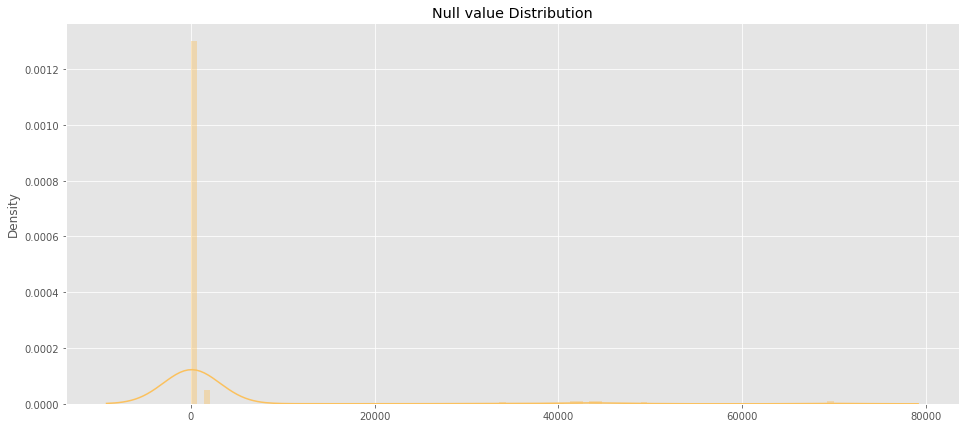

In [ ]:
plt.figure(figsize=(16,7))
sns.distplot(train.isna().sum(axis=0), bins=100, color=choice(color_pal), label='time_id')
plt.title("Null value Distribution")

plt.show()

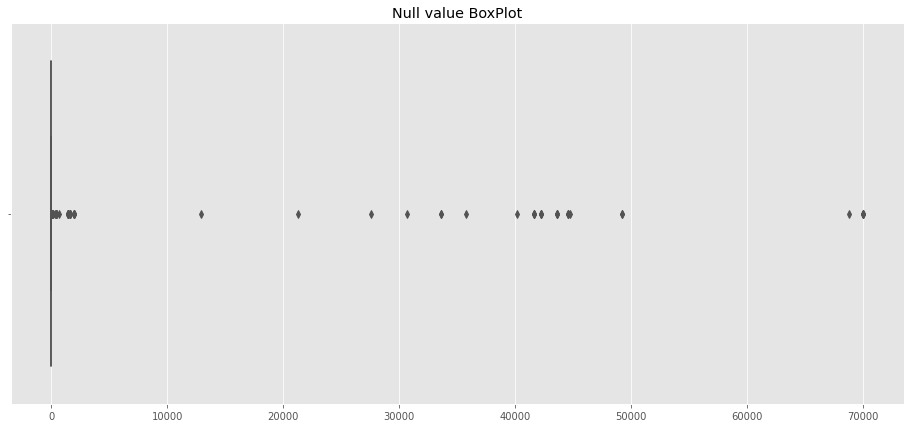

In [ ]:
plt.figure(figsize=(16,7))
sns.boxplot(train.isna().sum(axis=0), color=choice(color_pal))
plt.title("Null value BoxPlot")

plt.show()

In [ ]:
# drop all those Null value features

null_columns = ['feature_193', 'feature_196',	'feature_197',	'feature_198',	'feature_83']

train = train.drop(columns = null_columns)
test = test.drop(columns = null_columns)

print(train.shape, test.shape)

(70000, 504) (30000, 503)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 504 entries, id to feature_506
dtypes: float64(138), int64(274), object(92)
memory usage: 269.2+ MB


## Categorical Columns

In [ ]:
train.select_dtypes('object').head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_41,feature_42,feature_54,feature_55,feature_58,feature_97,feature_133,feature_134,feature_135,feature_152,feature_163,feature_164,feature_165,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_194,feature_195,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_336,feature_337,feature_338,feature_371
0,C0,C0,C1,C5,C11,C0,C60,C17795,C413,C3620,C0,C0,C0,C19,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C0,C4,C41,C16133,C2,C16,C0,C1,C1,C2,C1483,C6,C0,C0,C20,C0,11/10/2017,11/10/2017,09/11/2017,NaN,11/10/2017,NaN,11/10/2017,NaN,NaN,NaN,C5,C0,C1,C1,C1,C0,C2,C140,C91,C0,C1,C1,C0,C0,C66,C63,C25,C10,C2,C1,C0,C0,C105,C86,C30,C13,C2,C1,C0,C2,C166,C130,C46,C22,C10,C7,C6,C0,C0,C0,C0
1,C0,C0,C3,C5,C1,C2,C50,C14050,C413,C2819,C0,C0,C0,C23,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C0,C7,C41,C21195,C2,C16,C0,C3,C1,C11,C1483,C8,C0,C0,C21,C0,25/03/2015,25/03/2015,NaN,NaN,02/04/2017,25/03/2015,25/03/2015,NaN,NaN,25/03/2015,C9,C0,C2,C2,C1,C14,C3,C193,C66,C0,C1,C1,C0,C0,C80,C74,C29,C13,C5,C2,C1,C0,C128,C104,C36,C18,C6,C3,C2,C0,C130,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0
2,C0,C0,C3,C5,C2,C1,C76,C23471,C413,C4794,C0,C0,C0,C22,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C0,C7,C41,C11390,C2,C16,C0,C3,C1,C11,C1483,C4,C0,C0,C11,C0,27/01/2015,27/01/2015,13/05/2017,NaN,24/03/2016,27/01/2015,27/01/2015,NaN,NaN,27/01/2015,C9,C0,C2,C2,C1,C14,C3,C175,C66,C0,C1,C1,C0,C0,C80,C74,C29,C13,C5,C2,C1,C0,C128,C104,C36,C18,C6,C3,C2,C0,C130,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0
3,C0,C0,C1,C5,C1,C0,C58,C16929,C413,C3344,C0,C0,C0,C2,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C0,C7,C41,C22367,C2,C16,C0,C3,C1,C1,C1483,C2,C0,C0,C5,C0,05/02/2014,01/04/2014,NaN,19/03/2014,01/04/2014,01/04/2014,01/04/2014,31/03/2014,31/03/2014,05/02/2014,C0,C0,C2,C2,C1,C0,C3,C193,C13,C0,C1,C1,C0,C0,C78,C73,C28,C12,C3,C1,C0,C0,C103,C84,C28,C13,C2,C1,C0,C0,C104,C83,C28,C13,C2,C1,C0,C0,C0,C0,C0
4,C0,C0,C3,C3,C11,C2,C48,C13941,C413,C2753,C0,C0,C0,C3,C1,C1,C1,C1,C1,C1,C1,C0,C0,C0,C413,C0,C5,C1,C1652,C2,C16,C0,C0,C1,C11,C1483,C12,C0,C0,C11,C0,20/07/2009,10/09/2013,14/02/2017,NaN,10/09/2013,24/01/2016,10/09/2013,24/01/2016,10/09/2013,23/03/2011,C2,C0,C1,C1,C1,C0,C2,C60,C31,C0,C1,C1,C0,C0,C64,C61,C23,C10,C2,C1,C0,C0,C86,C69,C24,C11,C2,C1,C0,C0,C114,C93,C24,C11,C2,C1,C0,C0,C0,C0,C1


In [ ]:
date_columns = ['feature_191', 'feature_192',	'feature_194', 'feature_195',	'feature_199',
                'feature_200', 'feature_201',	'feature_202', 'feature_203',	'feature_204']

train[date_columns].head()

,feature_191,feature_192,feature_194,feature_195,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204
0,11/10/2017,11/10/2017,09/11/2017,NaN,11/10/2017,NaN,11/10/2017,NaN,NaN,NaN
1,25/03/2015,25/03/2015,NaN,NaN,02/04/2017,25/03/2015,25/03/2015,NaN,NaN,25/03/2015
2,27/01/2015,27/01/2015,13/05/2017,NaN,24/03/2016,27/01/2015,27/01/2015,NaN,NaN,27/01/2015
3,05/02/2014,01/04/2014,NaN,19/03/2014,01/04/2014,01/04/2014,01/04/2014,31/03/2014,31/03/2014,05/02/2014
4,20/07/2009,10/09/2013,14/02/2017,NaN,10/09/2013,24/01/2016,10/09/2013,24/01/2016,10/09/2013,23/03/2011


In [ ]:
train = train.drop(columns = date_columns)
test = test.drop(columns = date_columns)

print(train.shape, test.shape)

(70000, 494) (30000, 493)


In [ ]:
# Number of unique categories

train.select_dtypes('object').nunique().sort_values().to_frame().T

,feature_190,feature_55,feature_187,feature_188,feature_249,feature_248,feature_41,feature_42,feature_152,feature_338,feature_242,feature_34,feature_250,feature_270,feature_277,feature_278,feature_336,feature_337,feature_239,feature_33,feature_0,feature_31,feature_1,feature_32,feature_23,feature_27,feature_371,feature_30,feature_29,feature_28,feature_240,feature_286,feature_241,feature_276,feature_134,feature_244,feature_164,feature_163,feature_16,feature_285,feature_58,feature_275,feature_3,feature_251,feature_293,feature_284,feature_2,feature_292,feature_283,feature_205,feature_291,feature_4,feature_165,feature_186,feature_135,feature_243,feature_274,feature_282,feature_189,feature_290,feature_24,feature_97,feature_273,feature_281,feature_289,feature_272,feature_271,feature_247,feature_17,feature_280,feature_288,feature_287,feature_279,feature_246,feature_185,feature_19,feature_54,feature_21,feature_22,feature_20,feature_133,feature_18
0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,4,4,4,4,5,5,6,6,6,6,6,6,7,9,10,10,12,12,13,13,15,17,21,21,22,25,29,30,37,40,75,82,86,103,111,116,135,136,147,255,260,260,2327,2339,5841,7126,15858


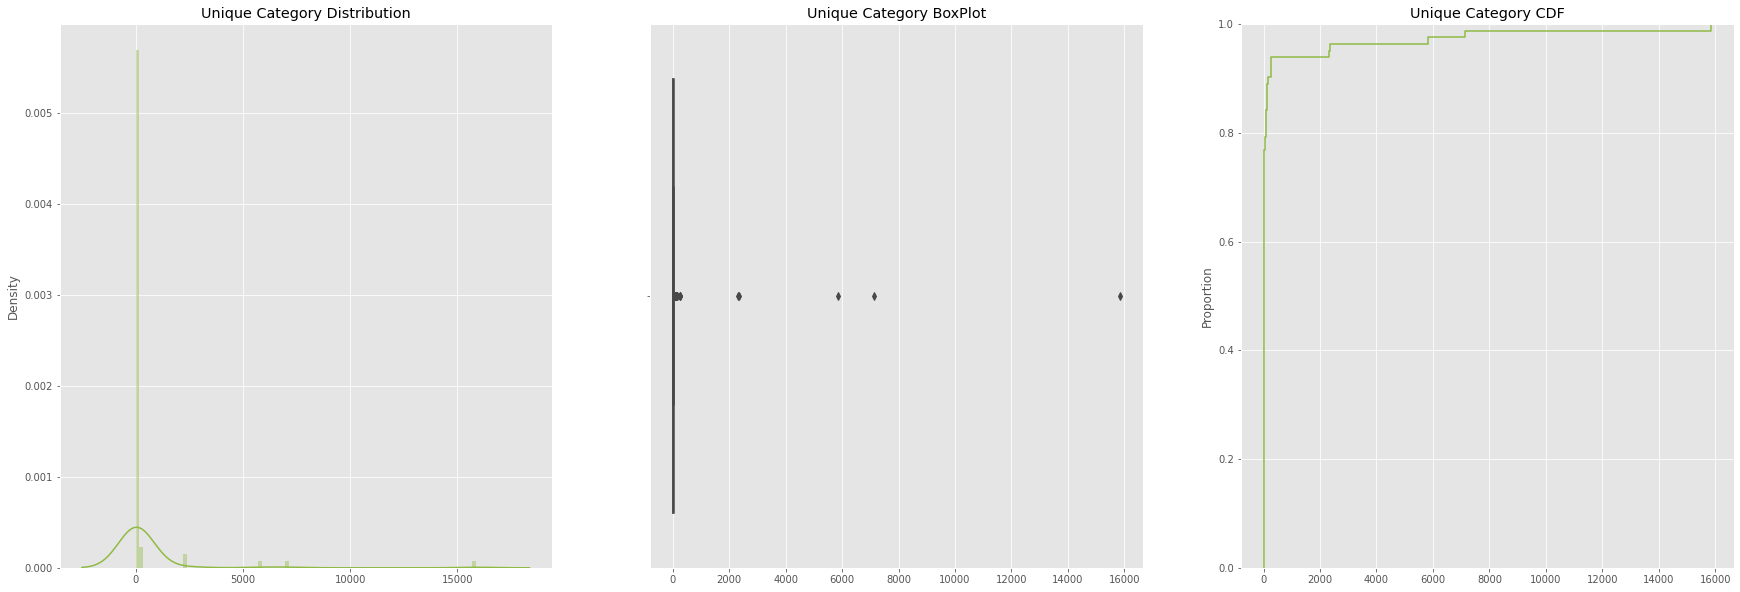

In [ ]:
plt.figure(figsize=(30,10))

plt.subplot(131)
sns.distplot(train.select_dtypes('object').nunique(), bins=100, color=choice(color_pal), label='time_id')
plt.title("Unique Category Distribution")

plt.subplot(132)
sns.boxplot(train.select_dtypes('object').nunique(), color=choice(color_pal))
plt.title("Unique Category BoxPlot")

plt.subplot(133)
sns.ecdfplot(train.select_dtypes('object').nunique(), color=choice(color_pal))
plt.title("Unique Category CDF")

plt.show()

In [ ]:
single_feature_columns_cat = ['feature_190',	'feature_55',	'feature_187',	'feature_188',	'feature_249',	'feature_248']

train[single_feature_columns_cat].head()

,feature_190,feature_55,feature_187,feature_188,feature_249,feature_248
0,C0,C0,C0,C0,C1,C0
1,C0,C0,C0,C0,C1,C0
2,C0,C0,C0,C0,C1,C0
3,C0,C0,C0,C0,C1,C0
4,C0,C0,C0,C0,C1,C0


In [ ]:
train = train.drop(columns = single_feature_columns_cat)
test = test.drop(columns = single_feature_columns_cat)

print(train.shape, test.shape)

(70000, 488) (30000, 487)


In [ ]:
train['feature_17'].nunique()

103

In [ ]:
# Dropping more than 100 categorical features

more_cat_features = ['feature_17', 'feature_18',	'feature_19',  'feature_20',	'feature_21',
                     'feature_22', 'feature_54',	'feature_133', 'feature_185',	'feature_246',
                     'feature_279', 'feature_280',	'feature_287',  'feature_288']

train[more_cat_features].head()

,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_54,feature_133,feature_185,feature_246,feature_279,feature_280,feature_287,feature_288
0,C60,C17795,C413,C3620,C0,C0,C413,C16133,C1483,C140,C105,C86,C166,C130
1,C50,C14050,C413,C2819,C0,C0,C413,C21195,C1483,C193,C128,C104,C130,C105
2,C76,C23471,C413,C4794,C0,C0,C413,C11390,C1483,C175,C128,C104,C130,C105
3,C58,C16929,C413,C3344,C0,C0,C413,C22367,C1483,C193,C103,C84,C104,C83
4,C48,C13941,C413,C2753,C0,C0,C413,C1652,C1483,C60,C86,C69,C114,C93


In [ ]:
train = train.drop(columns = more_cat_features)
test = test.drop(columns = more_cat_features)

print(train.shape, test.shape)

(70000, 474) (30000, 473)


In [ ]:
cat_columns = [col for col in train.select_dtypes('object').columns]

train[cat_columns].head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_16,feature_23,feature_24,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_41,feature_42,feature_58,feature_97,feature_134,feature_135,feature_152,feature_163,feature_164,feature_165,feature_186,feature_189,feature_205,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_247,feature_250,feature_251,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_289,feature_290,feature_291,feature_292,feature_293,feature_336,feature_337,feature_338,feature_371
0,C0,C0,C1,C5,C11,C0,C0,C19,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C4,C41,C2,C16,C0,C1,C1,C2,C6,C20,C5,C0,C1,C1,C1,C0,C2,C91,C1,C0,C0,C66,C63,C25,C10,C2,C1,C0,C0,C30,C13,C2,C1,C0,C2,C46,C22,C10,C7,C6,C0,C0,C0,C0
1,C0,C0,C3,C5,C1,C2,C0,C23,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C7,C41,C2,C16,C0,C3,C1,C11,C8,C21,C9,C0,C2,C2,C1,C14,C3,C66,C1,C0,C0,C80,C74,C29,C13,C5,C2,C1,C0,C36,C18,C6,C3,C2,C0,C36,C18,C6,C3,C2,C0,C0,C0,C0
2,C0,C0,C3,C5,C2,C1,C0,C22,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C7,C41,C2,C16,C0,C3,C1,C11,C4,C11,C9,C0,C2,C2,C1,C14,C3,C66,C1,C0,C0,C80,C74,C29,C13,C5,C2,C1,C0,C36,C18,C6,C3,C2,C0,C36,C18,C6,C3,C2,C0,C0,C0,C0
3,C0,C0,C1,C5,C1,C0,C0,C2,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C7,C41,C2,C16,C0,C3,C1,C1,C2,C5,C0,C0,C2,C2,C1,C0,C3,C13,C1,C0,C0,C78,C73,C28,C12,C3,C1,C0,C0,C28,C13,C2,C1,C0,C0,C28,C13,C2,C1,C0,C0,C0,C0,C0
4,C0,C0,C3,C3,C11,C2,C0,C3,C1,C1,C1,C1,C1,C1,C1,C0,C0,C0,C5,C1,C2,C16,C0,C0,C1,C11,C12,C11,C2,C0,C1,C1,C1,C0,C2,C31,C1,C0,C0,C64,C61,C23,C10,C2,C1,C0,C0,C24,C11,C2,C1,C0,C0,C24,C11,C2,C1,C0,C0,C0,C0,C1


## Numerical Columns

In [ ]:
train.select_dtypes(['int', 'float']).head()

,id,target,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_25,feature_26,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_56,feature_57,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_245,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,feature_357,feature_358,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364,feature_365,feature_366,feature_367,feature_368,feature_369,feature_370,feature_372,feature_373,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_385,feature_386,feature_387,feature_388,feature_389,feature_390,feature_391,feature_392,feature_393,feature_394,feature_395,feature_396,feature_397,feature_398,feature_399,feature_400,feature_401,feature_402,feature_403,feature_404,feature_405,feature_406,feature_407,feature_408,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418,feature_419,feature_420,feature_421,feature_422,feature_423,feature_424,feature_425,feature_426,feature_427,feature_428,feature_429,feature_430,feature_431,feature_432,feature_433,feature_434,feature_4

In [ ]:
target_column = 'target'
drop_columns = ['id', target_column]

In [ ]:
num_columns = [col for col in train.select_dtypes(['int', 'float']).columns if col not in drop_columns]

train[num_columns].head()

,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_25,feature_26,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_56,feature_57,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_245,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,feature_357,feature_358,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364,feature_365,feature_366,feature_367,feature_368,feature_369,feature_370,feature_372,feature_373,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_385,feature_386,feature_387,feature_388,feature_389,feature_390,feature_391,feature_392,feature_393,feature_394,feature_395,feature_396,feature_397,feature_398,feature_399,feature_400,feature_401,feature_402,feature_403,feature_404,feature_405,feature_406,feature_407,feature_408,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418,feature_419,feature_420,feature_421,feature_422,feature_423,feature_424,feature_425,feature_426,feature_427,feature_428,feature_429,feature_430,feature_431,feature_432,feature_433,feature_434,feature_435,feature

In [ ]:
# number of unique values

train[num_columns].nunique().sort_values().to_frame().T

,feature_227,feature_469,feature_149,feature_467,feature_405,feature_463,feature_461,feature_459,feature_357,feature_358,feature_455,feature_453,feature_451,feature_449,feature_445,feature_375,feature_433,feature_432,feature_395,feature_409,feature_228,feature_411,feature_412,feature_413,feature_472,feature_419,feature_100,feature_385,feature_421,feature_377,feature_425,feature_427,feature_389,feature_474,feature_465,feature_397,feature_493,feature_489,feature_505,feature_487,feature_312,feature_495,feature_313,feature_484,feature_491,feature_498,feature_482,feature_502,feature_476,feature_500,feature_252,feature_480,feature_478,feature_396,feature_120,feature_384,feature_261,feature_265,feature_294,feature_126,feature_388,feature_267,feature_263,feature_123,feature_394,feature_299,feature_327,feature_307,feature_329,feature_330,feature_325,feature_324,feature_148,feature_146,feature_323,feature_332,feature_376,feature_319,feature_317,feature_316,feature_315,feature_138,feature_373,feature_136,feature_374,feature_326,feature_333,feature_311,feature_506,feature_408,feature_471,feature_473,feature_475,feature_477,feature_479,feature_404,feature_50,feature_481,feature_47,feature_483,feature_468,feature_485,feature_488,feature_490,feature_492,feature_494,feature_496,feature_497,feature_499,feature_501,feature_503,feature_504,feature_486,feature_466,feature_51,feature_410,feature_99,feature_420,feature_464,feature_98,feature_424,feature_426,feature_102,feature_444,feature_448,feature_450,feature_103,feature_452,feature_112,feature_462,feature_454,feature_460,feature_458,feature_77,feature_107,feature_418,feature_113,feature_300,feature_298,feature_295,feature_393,feature_296,feature_301,feature_245,feature_302,feature_331,feature_304,feature_470,feature_334,feature_328,feature_335,feature_372,feature_322,feature_303,feature_321,feature_318,feature_314,feature_309,feature_308,feature_306,feature_305,feature_320,feature_310,feature_297,feature_45,feature_115,feature_46,feature_142,feature_143,feature_144,feature_48,feature_49,feature_52,feature_53,feature_101,feature_104,feature_105,feature_145,feature_147,feature_150,feature_151,feature_106,feature_108,feature_109,feature_110,feature_111,feature_117,feature_118,feature_116,feature_127,feature_125,feature_124,feature_43,feature_44,feature_140,feature_139,feature_122,feature_121,feature_119,feature_137,feature_141,feature_392,feature_78,feature_447,feature_446,feature_422,feature_69,feature_430,feature_423,feature_398,feature_266,feature_268,feature_399,feature_79,feature_431,feature_264,feature_262,feature_402,feature_400,feature_386,feature_380,feature_390,feature_382,feature_369,feature_406,feature_378,feature_436,feature_456,feature_442,feature_440,feature_438,feature_254,feature_434,feature_428,feature_114,feature_414,feature_71,feature_416,feature_269,feature_383,feature_67,feature_407,feature_439,feature_255,feature_415,feature_457,feature_443,feature_391,feature_429,feature_435,feature_403,feature_381,feature_379,feature_437,feature_387,feature_401,feature_417,feature_441,feature_370,feature_76,feature_75,feature_62,feature_72,feature_73,feature_70,feature_80,feature_87,feature_130,feature_68,feature_128,feature_129,feature_166,feature_63,feature_363,feature_367,feature_64,feature_341,feature_355,feature_359,feature_339,feature_59,feature_361,feature_74,feature_170,feature_56,feature_343,feature_347,feature_365,feature_57,feature_342,feature_176,feature_364,feature_82,feature_345,feature_253,feature_368,feature_340,feature_356,feature_351,feature_360,feature_349,feature_60,feature_61,feature_175,feature_353,feature_81,feature_362,feature_171,feature_181,feature_211,feature_167,feature_11,feature_344,feature_348,feature_366,feature_65,feature_173,feature_346,feature_85,feature_352,feature_90,feature_180,feature_233,feature_350,feature_209,feature_237,feature_212,feature_177,feature_84,feature_88,feature_12,feature_257,feature_256,feature_354,feature_210,feature_229,feature_178,

In [ ]:
single_features_num = [ 'feature_227',	'feature_469', 'feature_149',	'feature_467',	'feature_405',	'feature_463',
                    'feature_461',	'feature_459', 'feature_357',	'feature_358',	'feature_455',	'feature_453',	
                    'feature_451', 'feature_449',	 'feature_445',	'feature_375',	'feature_433',	'feature_432',	
                    'feature_395',	'feature_409',	'feature_228',	'feature_411',	'feature_412',	'feature_413',
                   	'feature_472',	'feature_419',	'feature_100',	'feature_385',	'feature_421',	'feature_377',
                   	'feature_425',	'feature_427',	'feature_389',	'feature_474',	'feature_465',	'feature_397',
                   	'feature_493',	'feature_489',	'feature_505',	'feature_487',	'feature_312',	'feature_495',	
                    'feature_313',	'feature_484',	'feature_491',	'feature_498',	'feature_482',	'feature_502',
                   	'feature_476',	'feature_500',	'feature_252',	'feature_480',	'feature_478']

train[single_features_num].head()

,feature_227,feature_469,feature_149,feature_467,feature_405,feature_463,feature_461,feature_459,feature_357,feature_358,feature_455,feature_453,feature_451,feature_449,feature_445,feature_375,feature_433,feature_432,feature_395,feature_409,feature_228,feature_411,feature_412,feature_413,feature_472,feature_419,feature_100,feature_385,feature_421,feature_377,feature_425,feature_427,feature_389,feature_474,feature_465,feature_397,feature_493,feature_489,feature_505,feature_487,feature_312,feature_495,feature_313,feature_484,feature_491,feature_498,feature_482,feature_502,feature_476,feature_500,feature_252,feature_480,feature_478
0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train = train.drop(columns = single_features_num)
test = test.drop(columns = single_features_num)

print(train.shape, test.shape)

(70000, 421) (30000, 420)


## Feature Distribution

In [ ]:
num_columns = [col for col in train.select_dtypes(['int', 'float']).columns if col not in drop_columns]

len(num_columns)

357

In [ ]:
top9_columns = train[num_columns].nunique().sort_values(ascending=False).index.values[:9]

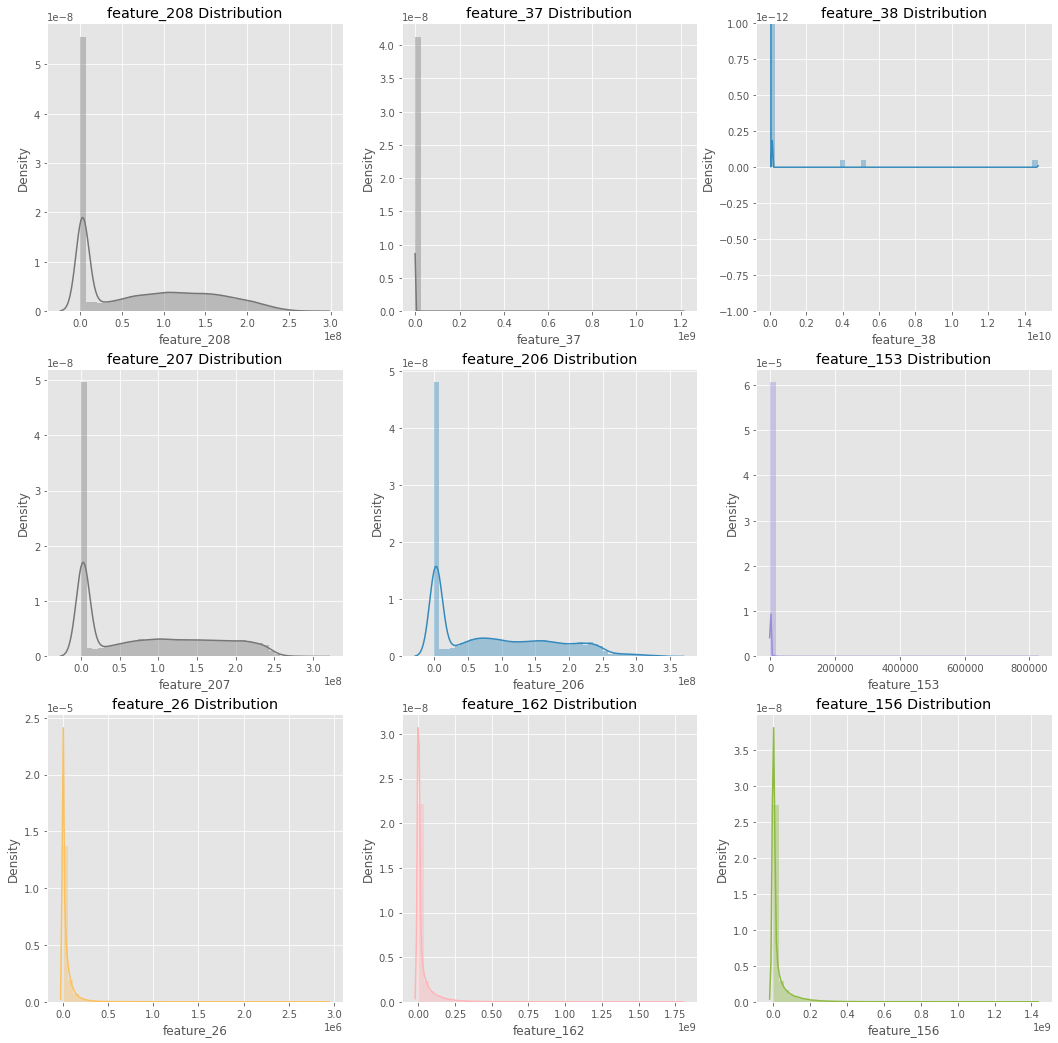

In [ ]:
fig, ax = plt.subplots(3,3, figsize = (18,18))

for i, col in enumerate(top9_columns):
  sns.distplot(train[col], color = choice(color_pal), ax=ax[math.floor(i/3), i%3]).set_title(f'{col} Distribution')

fig.show()

## Correlation Heatmap

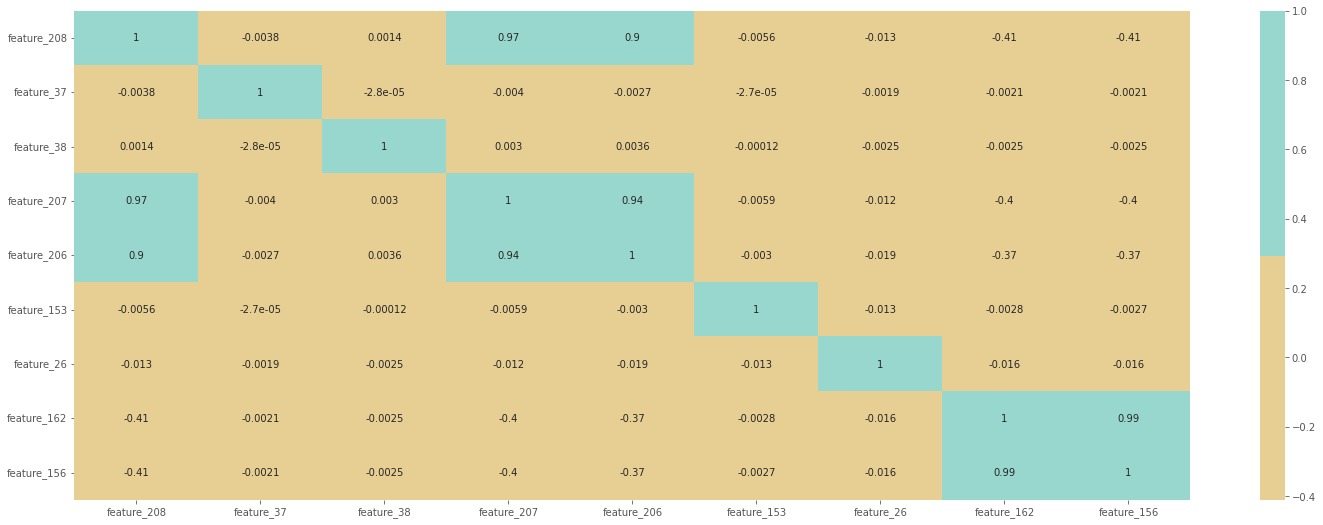

In [ ]:
corr_df = train[top9_columns].corr()

plt.figure(figsize = (25,9))
sns.heatmap(corr_df, annot= True, cmap=sns.color_palette("BrBG",2))


## Correlation of Target and Features

In [ ]:
corr_df = train[['target'] + num_columns].corr()

corr_df.head()

,target,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_25,feature_26,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_56,feature_57,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_98,feature_99,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_150,feature_151,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_245,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364,feature_365,feature_366,feature_367,feature_368,feature_369,feature_370,feature_372,feature_373,feature_374,feature_376,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_386,feature_387,feature_388,feature_390,feature_391,feature_392,feature_393,feature_394,feature_396,feature_398,feature_399,feature_400,feature_401,feature_402,feature_403,feature_404,feature_406,feature_407,feature_408,feature_410,feature_414,feature_415,feature_416,feature_417,feature_418,feature_420,feature_422,feature_423,feature_424,feature_426,feature_428,feature_429,feature_430,feature_431,feature_434,feature_435,feature_436,feature_437,feature_438,feature_439,feature_440,feature_441,feature_442,feature_443,feature_444,feature_446,feature_447,feature_448,feature_450,feature_452,feature_454,feature_456,feature_457,feature_458,feature_460,feature_462,feature_464,feature_466,feature_468,feature_470,feature_471,feature_473,

In [ ]:
corr_df['target'].abs().sort_values(ascending=False).to_frame().T

,target,feature_307,feature_297,feature_81,feature_108,feature_110,feature_7,feature_6,feature_82,feature_470,feature_5,feature_264,feature_254,feature_263,feature_143,feature_298,feature_43,feature_169,feature_328,feature_48,feature_224,feature_354,feature_223,feature_353,feature_132,feature_118,feature_168,feature_268,feature_302,feature_402,feature_440,feature_369,feature_386,feature_430,feature_376,feature_384,feature_374,feature_504,feature_388,feature_394,feature_396,feature_408,feature_404,feature_501,feature_410,feature_471,feature_497,feature_496,feature_494,feature_492,feature_490,feature_488,feature_486,feature_485,feature_483,feature_481,feature_479,feature_477,feature_475,feature_473,feature_468,feature_418,feature_466,feature_464,feature_462,feature_460,feature_458,feature_454,feature_452,feature_450,feature_448,feature_444,feature_503,feature_426,feature_424,feature_499,feature_420,feature_506,feature_422,feature_392,feature_372,feature_446,feature_398,feature_406,feature_416,feature_438,feature_442,feature_428,feature_378,feature_434,feature_456,feature_136,feature_382,feature_390,feature_436,feature_267,feature_400,feature_414,feature_67,feature_131,feature_380,feature_128,feature_127,feature_381,feature_306,feature_305,feature_174,feature_122,feature_329,feature_129,feature_415,feature_348,feature_173,feature_79,feature_347,feature_172,feature_208,feature_26,feature_45,feature_206,feature_80,feature_73,feature_91,feature_93,feature_78,feature_25,feature_92,feature_87,feature_301,feature_295,feature_245,feature_137,feature_383,feature_140,feature_46,feature_104,feature_53,feature_403,feature_141,feature_207,feature_77,feature_130,feature_86,feature_435,feature_139,feature_125,feature_124,feature_391,feature_68,feature_218,feature_217,feature_265,feature_266,feature_320,feature_437,feature_352,feature_151,feature_309,feature_167,feature_366,feature_351,feature_304,feature_115,feature_147,feature_308,feature_365,feature_346,feature_66,feature_70,feature_345,feature_441,feature_236,feature_148,feature_65,feature_171,feature_235,feature_170,feature_300,feature_318,feature_370,feature_256,feature_260,feature_335,feature_126,feature_258,feature_296,feature_138,feature_99,feature_387,feature_294,feature_429,feature_182,feature_177,feature_60,feature_322,feature_101,feature_15,feature_257,feature_51,feature_156,feature_319,feature_162,feature_457,feature_85,feature_259,feature_166,feature_216,feature_13,feature_14,feature_356,feature_215,feature_161,feature_44,feature_155,feature_368,feature_303,feature_261,feature_340,feature_160,feature_210,feature_339,feature_154,feature_255,feature_209,feature_181,feature_69,feature_96,feature_220,feature_212,feature_367,feature_10,feature_342,feature_211,feature_12,feature_142,feature_158,feature_355,feature_341,feature_226,feature_94,feature_74,feature_157,feature_222,feature_114,feature_439,feature_90,feature_95,feature_417,feature_253,feature_219,feature_399,feature_360,feature_72,feature_176,feature_221,feature_401,feature_111,feature_225,feature_184,feature_314,feature_159,feature_333,feature_11,feature_119,feature_71,feature_299,feature_109,feature_359,feature_325,feature_61,feature_88,feature_323,feature_407,feature_331,feature_144,feature_179,feature_332,feature_39,feature_35,feature_84,feature_379,feature_49,feature_230,feature_117,feature_36,feature_334,feature_103,feature_310,feature_311,feature_229,feature_316,feature_349,feature_150,feature_121,feature_361,feature_443,feature_112,feature_324,feature_350,feature_373,feature_269,feature_40,feature_123,feature_344,feature_47,feature_146,feature_56,feature_57,feature_107,feature_89,feature_153,feature_38,feature_231,feature_175,feature_317,feature_447,feature_9,feature_37,feature_362,feature_237,feature_178,feature_321,feature_238,feature_106,feature_363,feature_145,feature_393,feature_180,feature_76,feature_75,feature_214,feature_431,feature_105,feature_120,feature_343,feature_62,feature_50,feature_233,feature_183,featu

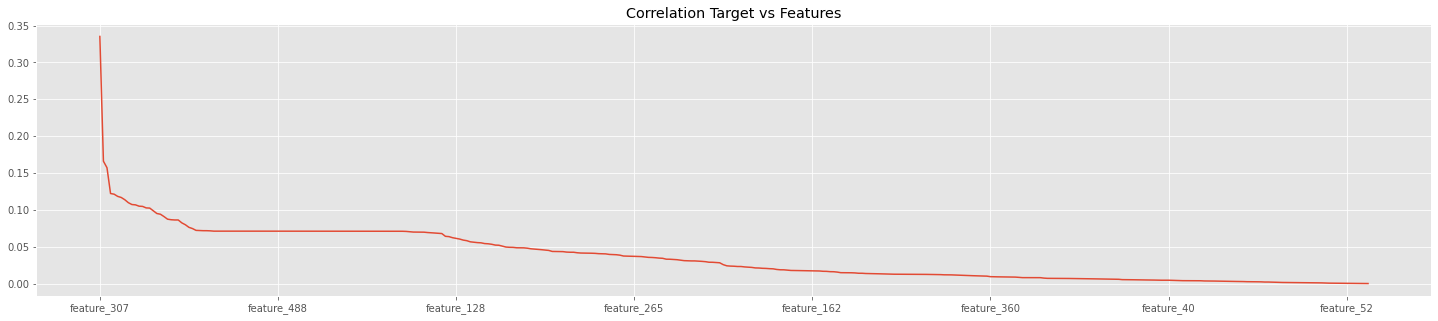

In [ ]:
plt.figure(figsize = (25,5))
corr_df['target'].abs().sort_values(ascending=False).iloc[1:].plot()
plt.title("Correlation Target vs Features")
plt.show()

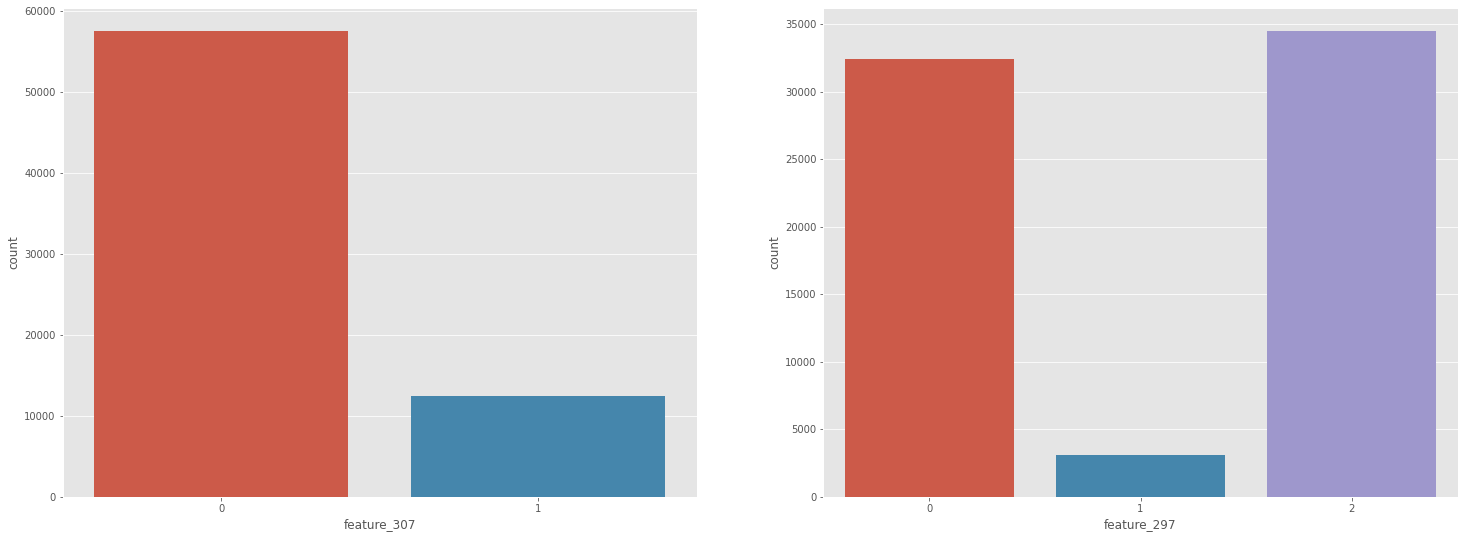

In [ ]:
plt.figure(figsize = (25,9))

#feature_307
plt.subplot(121)
sns.countplot(train['feature_307'])

#feature_297
plt.subplot(122)
sns.countplot(train['feature_297'])

plt.show()

In [ ]:
# feature_307 --- Feature AUC with Target
metrics.roc_auc_score(train['target'], train['feature_307']) 

0.6401047553543626


without any model we can get 0.64 AUC

## Preprocessing

In [ ]:
# label encoding those cat columns

def label_encoding(train_df, test_df, columns):
  for col in columns:
    le = preprocessing.LabelBinarizer()
    values = train_df[col].append(test_df[col])
    le.fit(values)
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
  return train_df, test_df

train, test = label_encoding(train, test, cat_columns)

train[cat_columns].head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_16,feature_23,feature_24,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_41,feature_42,feature_58,feature_97,feature_134,feature_135,feature_152,feature_163,feature_164,feature_165,feature_186,feature_189,feature_205,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_247,feature_250,feature_251,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_289,feature_290,feature_291,feature_292,feature_293,feature_336,feature_337,feature_338,feature_371
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1


## Modeling


In [ ]:
target_col = 'target'
drop_cols = [target_col, 'id']
train_cols = [col for col in train.columns if col not in drop_cols]

## Hyperparameter Tunning

In [ ]:
def run_lgbm(train_df, train_cols, target_col, params):

    skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_predictions = []

    oof_predictions_proba = np.zeros(len(train))

    for idx, (train_idx, valid_idx) in enumerate(skf.split(train, train[target_col])):

        X_train = train.iloc[train_idx][train_cols]
        y_train = train.iloc[train_idx][target_col]

        X_valid = train.iloc[valid_idx][train_cols]
        y_valid = train.iloc[valid_idx][target_col]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='auc', verbose=-1)

        y_valid_pred = model.predict_proba(X_valid)[:, 1]
        oof_predictions_proba[valid_idx] = y_valid_pred

    score = metrics.roc_auc_score(train[target_col], oof_predictions_proba)
    
    return score

## Model Training

LGBM

In [ ]:
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
test_predictions = []

oof_predictions_proba = np.zeros(len(train))

X_test = test[train_cols]

for idx, (train_idx, valid_idx) in enumerate(skf.split(train, train[target_col])):

    print("="*100)
    print("FOLD : ", idx)
    print("_"*100)

    X_train = train.iloc[train_idx][train_cols]
    y_train = train.iloc[train_idx][target_col]

    X_valid = train.iloc[valid_idx][train_cols]
    y_valid = train.iloc[valid_idx][target_col]
    
    print("Trian :", X_train.shape, y_train.shape)
    print("Valid :", X_valid.shape, y_valid.shape)
    
    params ={ 'learning_rate': 5e-2, 'n_estimators': 10000, 'n_jobs': -1,
              'lambda_l1': 5.648213390404352, 'lambda_l2': 2.6929573628620292e-06, 
              'num_leaves': 14, 'feature_fraction': 0.5688315101003765, 
              'bagging_fraction': 0.8794508967010554, 'bagging_freq': 5, 
              'min_child_samples': 51, 'subsample': 0.8447983529661222 }
    

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
              early_stopping_rounds=200, eval_metric='auc', verbose=100)

    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    predictions = model.predict_proba(X_test)[:, 1]

    test_predictions.append(predictions)
    oof_predictions_proba[valid_idx] = y_valid_pred

score = metrics.roc_auc_score(train[target_col], oof_predictions_proba)
test_predictions = np.mean(test_predictions, axis=0)
lgbm_test_predictions = test_predictions

print("OOF MEAN AUC :", score)

FOLD :  0
____________________________________________________________________________________________________
Trian : (56000, 419) (56000,)
Valid : (14000, 419) (14000,)
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's binary_logloss: 0.498102	valid_0's auc: 0.784454
[200]	valid_0's binary_logloss: 0.494796	valid_0's auc: 0.787243
[300]	valid_0's binary_logloss: 0.494208	valid_0's auc: 0.787606
[400]	valid_0's binary_logloss: 0.493859	valid_0's auc: 0.787976
[500]	valid_0's binary_logloss: 0.494151	valid_0's auc: 0.787523
Early stopping, best iteration is:
[397]	valid_0's binary_logloss: 0.493852	valid_0's auc: 0.787992
FOLD :  1
____________________________________________________________________________________________________
Trian : (56000, 419) (56000,)
Valid : (14000, 419) (14000,)
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's binary_logloss: 0.503075	valid_0's auc: 0.776983
[200]	valid_0's binary_logloss: 0.501319	v

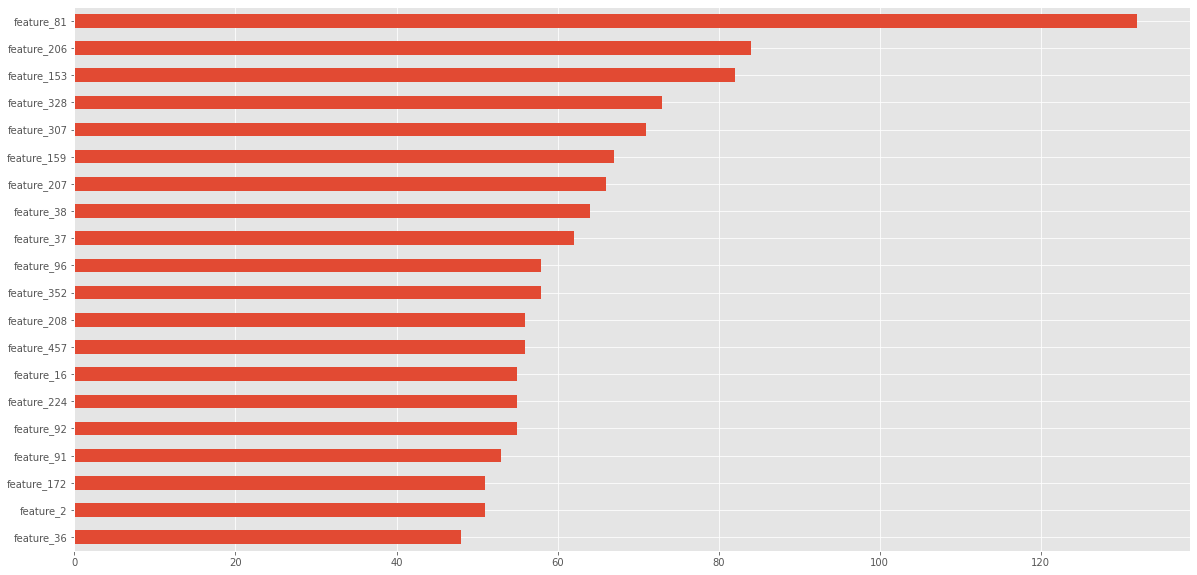

In [ ]:
# feature importance

fig, ax = plt.subplots(figsize=(20, 10))
fi = pd.Series(index = train_cols, data = model.feature_importances_)
fi.sort_values(ascending=False)[0:20][::-1].plot(kind = 'barh')
plt.show()

Catboost

In [ ]:
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
test_predictions = []

oof_predictions_proba = np.zeros(len(train))

X_test = test[train_cols]

for idx, (train_idx, valid_idx) in enumerate(skf.split(train, train[target_col])):

    print("="*100)
    print("FOLD : ", idx)
    print("_"*100)

    X_train = train.iloc[train_idx][train_cols]
    y_train = train.iloc[train_idx][target_col]

    X_valid = train.iloc[valid_idx][train_cols]
    y_valid = train.iloc[valid_idx][target_col]
    
    print("Trian :", X_train.shape, y_train.shape)
    print("Valid :", X_valid.shape, y_valid.shape)
    
    params = {
        #'learning_rate': 5e-3,
        'n_estimators': 10000, 
        #'n_jobs': -1,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'use_best_model': True }
    

    model = cat.CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
            early_stopping_rounds=200, verbose=100)
            #eval_metric='auc',
            

    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    predictions = model.predict_proba(X_test)[:, 1]

    test_predictions.append(predictions)
    oof_predictions_proba[valid_idx] = y_valid_pred

score = metrics.roc_auc_score(train[target_col], oof_predictions_proba)
test_predictions = np.mean(test_predictions, axis=0)
catboost_test_predictions = test_predictions

print("OOF MEAN AUC :", score)

FOLD :  0
____________________________________________________________________________________________________
Trian : (56000, 419) (56000,)
Valid : (14000, 419) (14000,)
Learning rate set to 0.031457
0:	test: 0.7381701	best: 0.7381701 (0)	total: 192ms	remaining: 32m 4s
100:	test: 0.7783372	best: 0.7783372 (100)	total: 11.1s	remaining: 18m 10s
200:	test: 0.7828393	best: 0.7828393 (200)	total: 25.2s	remaining: 20m 29s
300:	test: 0.7845803	best: 0.7845803 (300)	total: 41.4s	remaining: 22m 13s
400:	test: 0.7856509	best: 0.7856509 (400)	total: 57.8s	remaining: 23m 4s
500:	test: 0.7861468	best: 0.7862213 (492)	total: 1m 19s	remaining: 25m 3s
600:	test: 0.7863190	best: 0.7863683 (576)	total: 1m 29s	remaining: 23m 20s
700:	test: 0.7862449	best: 0.7863803 (622)	total: 1m 44s	remaining: 23m 10s
800:	test: 0.7864708	best: 0.7864774 (792)	total: 1m 54s	remaining: 21m 59s
900:	test: 0.7864427	best: 0.7865538 (821)	total: 2m 8s	remaining: 21m 41s
1000:	test: 0.7863855	best: 0.7865538 (821)	total: 2

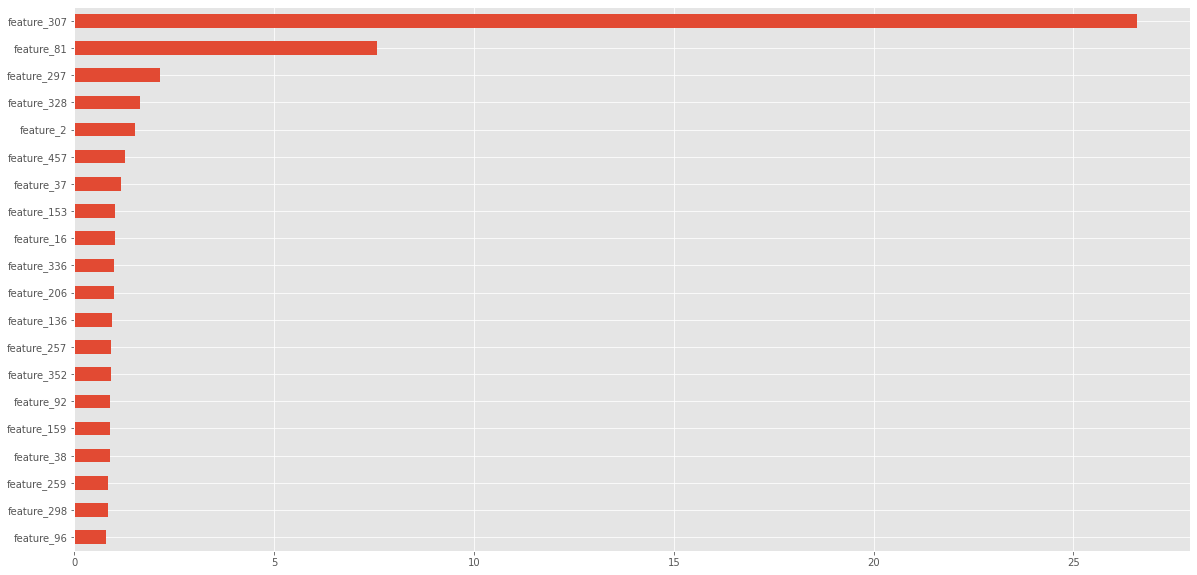

In [ ]:
# feature importance

fig, ax = plt.subplots(figsize=(20, 10))
fi = pd.Series(index = train_cols, data = model.feature_importances_)
fi.sort_values(ascending=False)[0:20][::-1].plot(kind = 'barh')
plt.show()

Ensemble

In [ ]:
test_predictions = 0.5 * lgbm_test_predictions + 0.5 * catboost_test_predictions

In [ ]:
ss['target'] = test_predictions
ss.head()

,id,target
0,5,0.431291
1,7,0.386464
2,9,0.351853
3,11,0.123756
4,14,0.232693


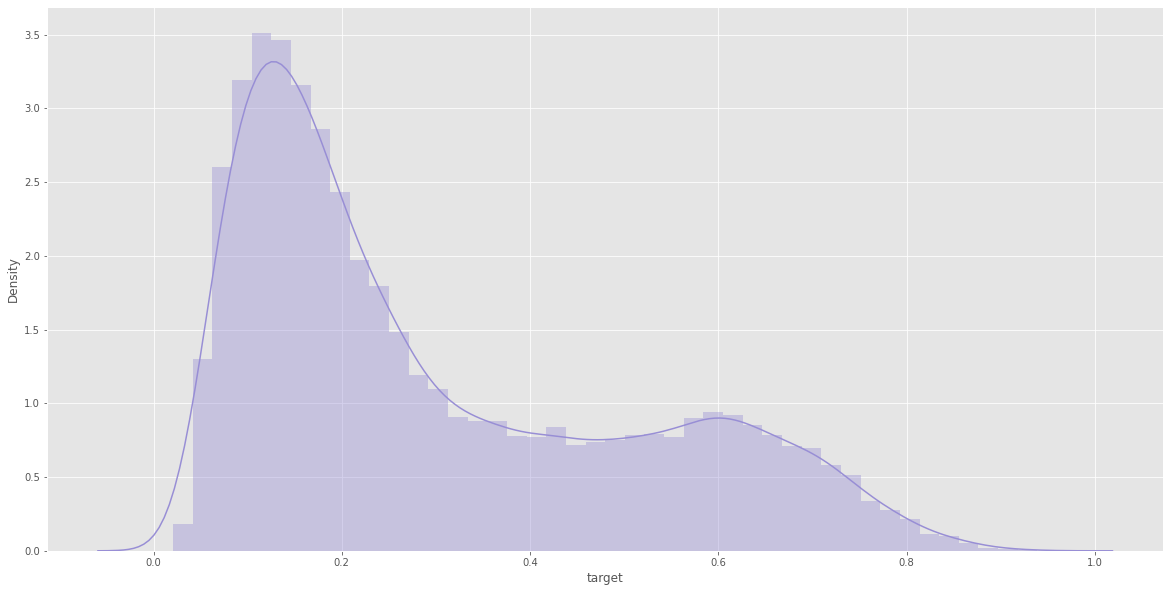

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(ss['target'], color=choice(color_pal), ax=ax)
plt.show()

In [ ]:
ss.to_csv("submission.csv", index=False)

In [ ]:
! kaggle competitions submit -c netflix-appetency -f submission.csv -m "EDA+Model"

100% 744k/744k [00:00<00:00, 2.88MB/s]
Successfully submitted to Netflix Appetency

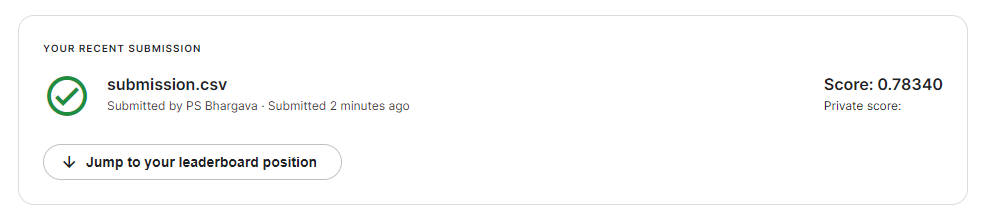